# ECON408: Assignment 4

Instructor: Jesse Perla, UBC

## Student Name/Number: (doubleclick to edit)

### Instructions

-   Edit the above cell to include your name and student number.
-   Submit a **both** the **executed** Jupyter notebook (`.ipynb`) and a
    rendered PDF file. To save as PDF, you can use the `File` menu in
    Jupyter Lab or choose `Export` for the built-in VS Code. No need to
    use a naming convention since Canvas takes care of that for you.
-   Edit code within this notebook in the provided blanks, but feel free
    to add in extra code markup and other cells.
-   Open local to the `Project.toml` and `Manifest.toml` provided files
    in this repository or the [QuantEcon Julia
    notebooks](https://github.com/QuantEcon/lecture-julia.notebooks).

In [1]:
using Distributions, Plots, LaTeXStrings, LinearAlgebra, Statistics, Random, QuantEcon

## Question 1

Take the example in [Simple Example with iid
Income](https://julia.quantecon.org/dynamic_programming/perm_income.html#a-simple-example-with-iid-income)
where the stochastic process for income $y_t$ follows

$$
y_t = \mu + \sigma w_t \sim N(\mu, \sigma^2)
$$

Under these assumptions, with quadratic utility and if $\beta R = 1$ the
optimal policy is

$$
\mathbb{E}_t\{c_{t+1}\} = c_t
$$

Which we can use to derive for this income process if $b_0 = y_0 = 0$.

$$
c_t = (1-\beta)\left(\mathbb{E}_t\left[\sum_{j=0}^\infty \beta^j y_{t+j}\right] - b_t\right) =  \mu + (1 - \beta) \sigma \sum_{j=1}^t w_j
$$

And finally

$$
b_t  = - \sigma \sum_{j=1}^{t-1} w_j
$$

### Part (a)

Code to simulate this consumption process for $t = 1, \ldots T$ is given
below.

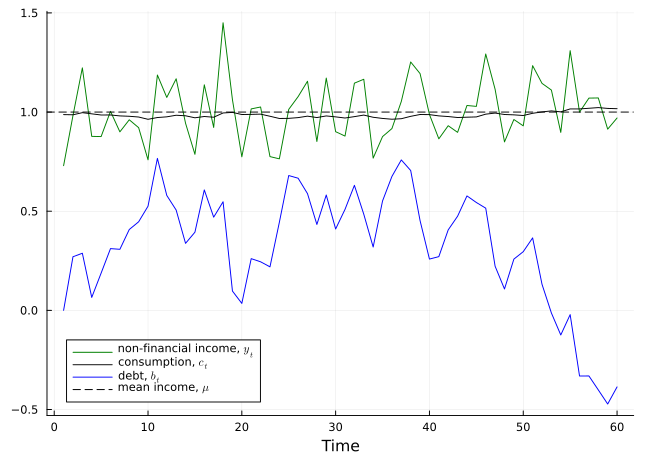

In [2]:
using Plots, Random


function simulate_iid_income(p, T; w = randn(T)) # pass in random draws for "w" or use default
    w_sum = cumsum(w) #(w_1, w_1 + w_2, w_1 + w_2 + w_3, ... sum_{j=1}^T w_j))    
    c = p.μ .+ (1 - p.β) * p.σ  * w_sum # (c_1, c_2, ... c_T)
    y = p.μ .+ p.σ * w # (y_1, y_2, ... y_T)
    b = [0.0; -p.σ * w_sum[1:end-1]] #(b_1, b_2, ... b_T), see offset in formula
    return (;w, b, c, y)
end

p = (;β= 1.0 / (1.0 + 0.05), μ = 1.0, σ = 0.15)
T = 60
res = simulate_iid_income(p, T)

plot(1:T, res.y, color = :green, label = L"non-financial income, $y_t$", xlabel="Time")
plot!(res.c, color = :black, label = L"consumption, $c_t$")
plot!(res.b, color = :blue, label = L"debt, $b_t$")
hline!([p.μ], color = :black, linestyle = :dash, label = L"mean income, $\mu$")

Using this code, plot call the above where instead of randomly drawing
each $w \sim N(0,1)$ draw it from a distribution $w \sim N(0.5, 1)$ and
plot the results

In [3]:
# edit your code here

### Part (b)

Interpret the result of the previous graph with the standard one with
well-specified results from the perspective of consumption smoothing and
forecasting of income. In what ways is the behavior in the second case
not optimal and why?

(double click to edit your answer)

## Question 2

Continuing with income process defined in Part 1, rather than manually
implementing this process, we will implement this as a linear
state-space model with the [state space
representation](https://python.quantecon.org/perm_income.html#a-state-space-representation).
As a reminder, if the income process follows a LSS model as in

$$
\begin{align}
    z_{t+1} &= A z_t + C w_t \\
    y_t &= U z_t\\
    w_t & \sim N(0,I)
\end{align}
$$

Then we can define

$$
x_t =
\begin{bmatrix}
    z_t\\
    b_t
\end{bmatrix},
\quad
\tilde A =
\begin{bmatrix}
    A & 0 \\
    U(I-\beta A)^{-1}(A-I) & 1
 \end{bmatrix},
 \quad
\tilde C =
\begin{bmatrix}
    C\\
    0
\end{bmatrix}
$$

and

$$
\tilde U =
\begin{bmatrix}
    U & 0 \\
    (1-\beta) U (I - \beta A)^{-1} & -(1-\beta)
\end{bmatrix}, \quad
\tilde y_t =
\begin{bmatrix}
      y_t\\
      c_t
  \end{bmatrix}
$$

Finally, this leads to the following state space representation for the
solution itself

$$
\begin{align}
  x_{t+1} & = \tilde A x_t + \tilde C w_{t+1} \\
  \tilde y_t & = \tilde U x_t
\end{align}
$$

### Part (a)

We can write the LSS for the income process in Question 1 as

$$
z_t =
\begin{bmatrix}
    z^1_t \\
    1
\end{bmatrix},
\quad
A =
\begin{bmatrix}
    0 & 0 \\
    0 & 1 \\
\end{bmatrix},
\quad
U =
\begin{bmatrix}
    1 & \mu
\end{bmatrix},
\quad
C =
\begin{bmatrix}
    \sigma \\
    0
\end{bmatrix}
$$

The code below is a basic template implementing a LSS model (in this
case, it simulates $y_{t+1} = 0.2 + 0.9 x_t + 0.05 y_{t+1}$ from an
initial condition of $y_0 = 1.5$).

Start the process at $b_0 = 0.0, z_t^0 = 0.0$. Hint: the most convenient
$x_t$ state is $x_t = [1, z^1_t, b_t]$.

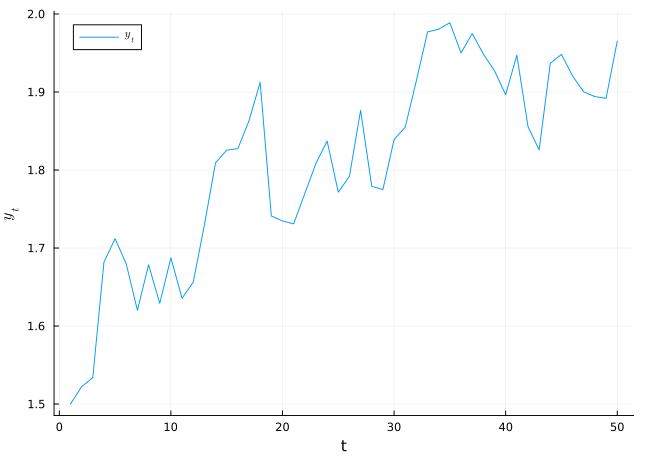

In [6]:
# Parameter values from above
p = (;β= 1.0 / (1.0 + 0.05), μ = 1.0, σ = 0.15)
x_0 = [0.0, 1.0, 1.0]
T = 60

# MODIFY the following template
# using a state of x_t = [1 y_t]
mu_0 = [1.0, 1.5] # adds the constant term to start at 1.0
A = [1.0 0
     0.2 0.9]
C = [0.0
     0.05]
G = [0.0 1.0]
T = 50
lss = LSS(A, C, G; mu_0)
x, y = simulate(lss, T)
plot(1:T, y[1,:], label=L"y_t", xlabel="t", ylabel=L"y_t")

Try to make the plot of consumption and income as a function of time as
you did in Question 1 (don’t worry about $b_t$).

### Part (b)

Try calculating the stationary distribution by modifying the code below
or trying with your existing code.

In [8]:
# modify here from previous results
μ_x, μ_y, Σ_x, Σ_y = stationary_distributions(lss)

([1.0, 1.999911517827286], [1.999911517827286], [0.0 0.0; 0.0 0.013157894324784486], [0.013157894324784486;;])

Explain why it does or does not converge below

(double click to edit your answer)